In [1]:
import missingno as msno
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import KFold, cross_val_score
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from category_encoders import BinaryEncoder
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer, KNNImputer,MissingIndicator
from sklearn.compose import ColumnTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import  GridSearchCV
from sklearn.preprocessing import FunctionTransformer


df = pd.read_csv(r"heart_capped.csv")
df.drop(columns = ['id','dataset'],inplace = True)
# Step 1: Create missing indicator BEFORE split
df['ca'] = df['ca'].isnull().astype(int)


# Step 3: Now split your dataset
from sklearn.model_selection import train_test_split
X = df.drop(columns='num', axis = 1)  # or whatever your label is
y = df['num']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 0: Split
X = df.drop('num', axis=1)
y = df['num']
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='num'), df['num'], test_size=0.2, random_state=42)

# Step 1: Ordinal encode all categorical
cat_features = ['cp', 'restecg', 'slope', 'thal', 'sex', 'exang', 'fbs', 'ca']
num_features = [col for col in X.columns if col not in cat_features]


# ================================
# Step 2: Try Imputation Pipelines
# Encode Categorical Variable using Column Transformer


# Encoding Categorical Variable

In [2]:
orginal_order = X_train.columns
orginal_order

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalch',
       'exang', 'oldpeak', 'slope', 'ca', 'thal'],
      dtype='object')

In [3]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 736 entries, 880 to 102
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       736 non-null    int64  
 1   sex       736 non-null    object 
 2   cp        736 non-null    object 
 3   trestbps  690 non-null    float64
 4   chol      572 non-null    float64
 5   fbs       656 non-null    object 
 6   restecg   735 non-null    object 
 7   thalch    694 non-null    float64
 8   exang     694 non-null    object 
 9   oldpeak   691 non-null    float64
 10  slope     498 non-null    object 
 11  ca        736 non-null    int32  
 12  thal      346 non-null    object 
dtypes: float64(4), int32(1), int64(1), object(7)
memory usage: 77.6+ KB


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       920 non-null    int64  
 1   sex       920 non-null    object 
 2   cp        920 non-null    object 
 3   trestbps  860 non-null    float64
 4   chol      718 non-null    float64
 5   fbs       830 non-null    object 
 6   restecg   918 non-null    object 
 7   thalch    865 non-null    float64
 8   exang     865 non-null    object 
 9   oldpeak   858 non-null    float64
 10  slope     611 non-null    object 
 11  ca        920 non-null    int32  
 12  thal      434 non-null    object 
 13  num       920 non-null    int64  
dtypes: float64(4), int32(1), int64(2), object(7)
memory usage: 97.2+ KB


In [5]:
X_train.isnull().sum()/920*100

age          0.000000
sex          0.000000
cp           0.000000
trestbps     5.000000
chol        17.826087
fbs          8.695652
restecg      0.108696
thalch       4.565217
exang        4.565217
oldpeak      4.891304
slope       25.869565
ca           0.000000
thal        42.391304
dtype: float64

### Imputing  Categorical Columns with Missing Values less then 10 percent


In [6]:
cat_imputer = SimpleImputer(strategy = 'most_frequent')

X_train[['fbs', 'restecg', 'exang']] = cat_imputer.fit_transform(X_train[['fbs', 'restecg', 'exang']])
X_test[['fbs', 'restecg', 'exang']] = cat_imputer.transform(X_test[['fbs', 'restecg', 'exang']])


In [7]:
X_train

,age,sex,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal
880,62,Male,asymptomatic,NaN,170.0,False,st-t abnormality,120.0,True,3.0,NaN,1,NaN
457,54,Male,non-anginal,150.0,NaN,False,normal,122.0,False,0.0,NaN,1,NaN
797,51,Male,non-anginal,NaN,339.0,False,normal,NaN,False,NaN,NaN,1,NaN
25,50,Female,non-anginal,120.0,219.0,False,normal,158.0,False,1.6,flat,0,normal
84,52,Male,atypical angina,120.0,325.0,False,normal,172.0,False,0.2,upsloping,0,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,59,Male,asymptomatic,140.0,177.0,False,normal,162.0,True,0.0,upsloping,0,reversable defect
270,61,Male,asymptomatic,140.0,207.0,False,lv hypertrophy,138.0,True,1.9,upsloping,0,reversable defect
860,75,Male,asymptomatic,160.0,310.0,True,normal,112.0,True,2.0,downsloping,1,reversable defect
435,53,Female,atypical angina,140.0,216.0,False,normal,142.0,True,2.0,flat,1,NaN


In [8]:
X_train.isnull().sum()/920*100

age          0.000000
sex          0.000000
cp           0.000000
trestbps     5.000000
chol        17.826087
fbs          0.000000
restecg      0.000000
thalch       4.565217
exang        0.000000
oldpeak      4.891304
slope       25.869565
ca           0.000000
thal        42.391304
dtype: float64

<Axes: >

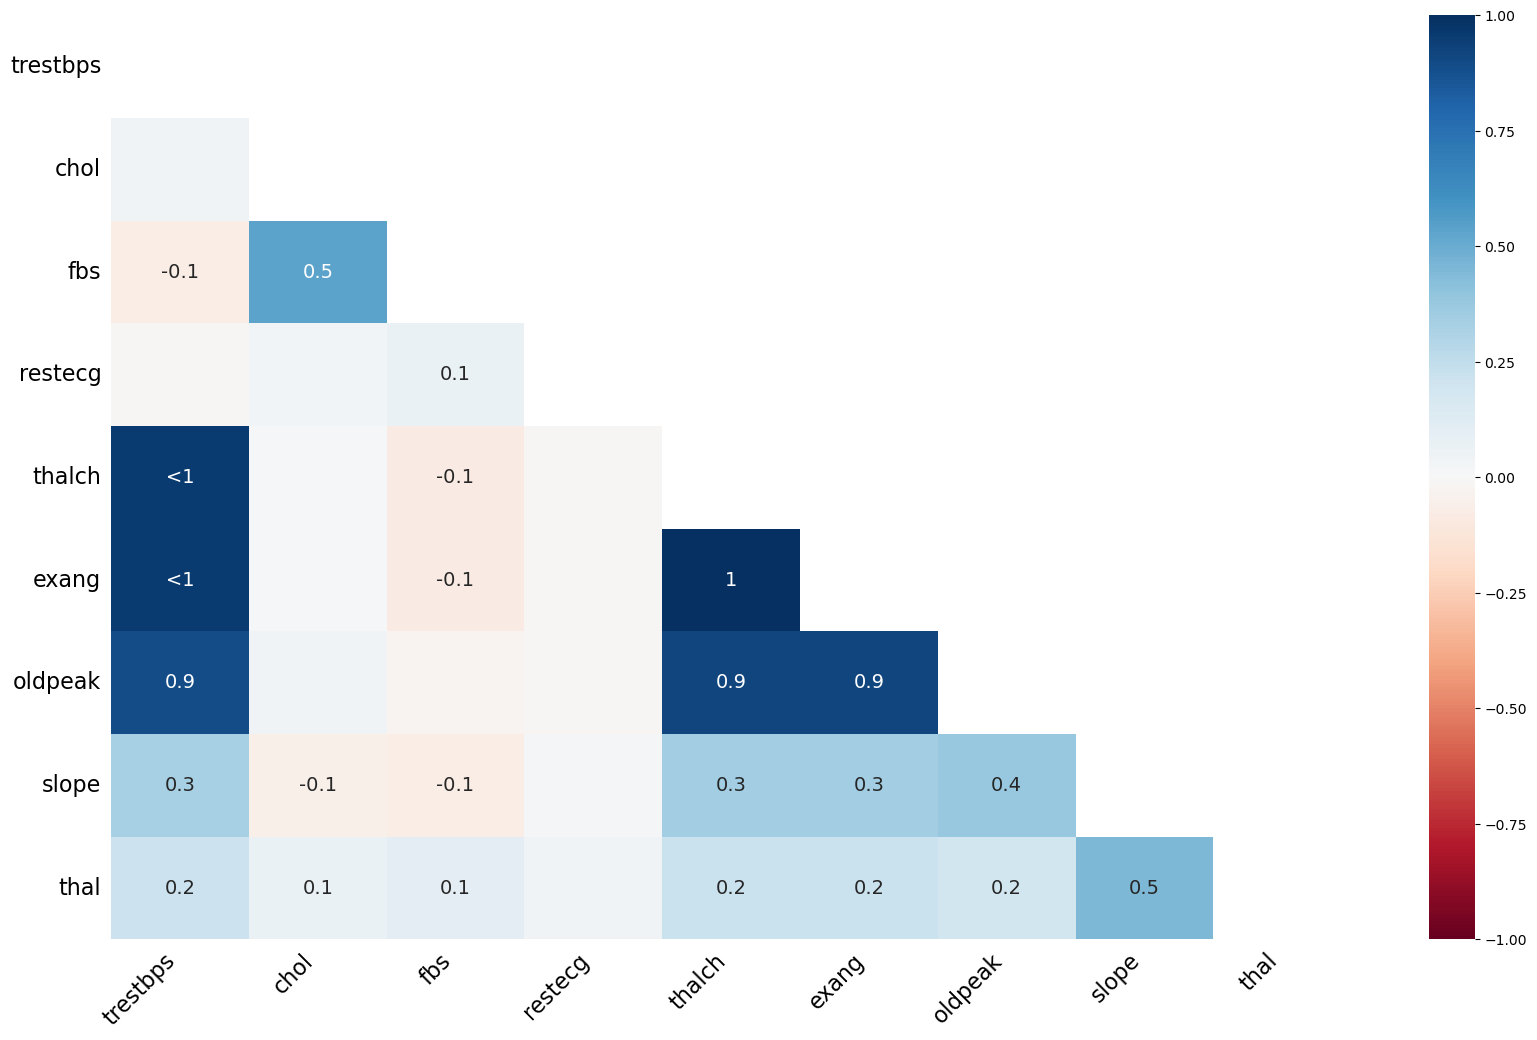

In [9]:
msno.heatmap(df)

<Axes: >

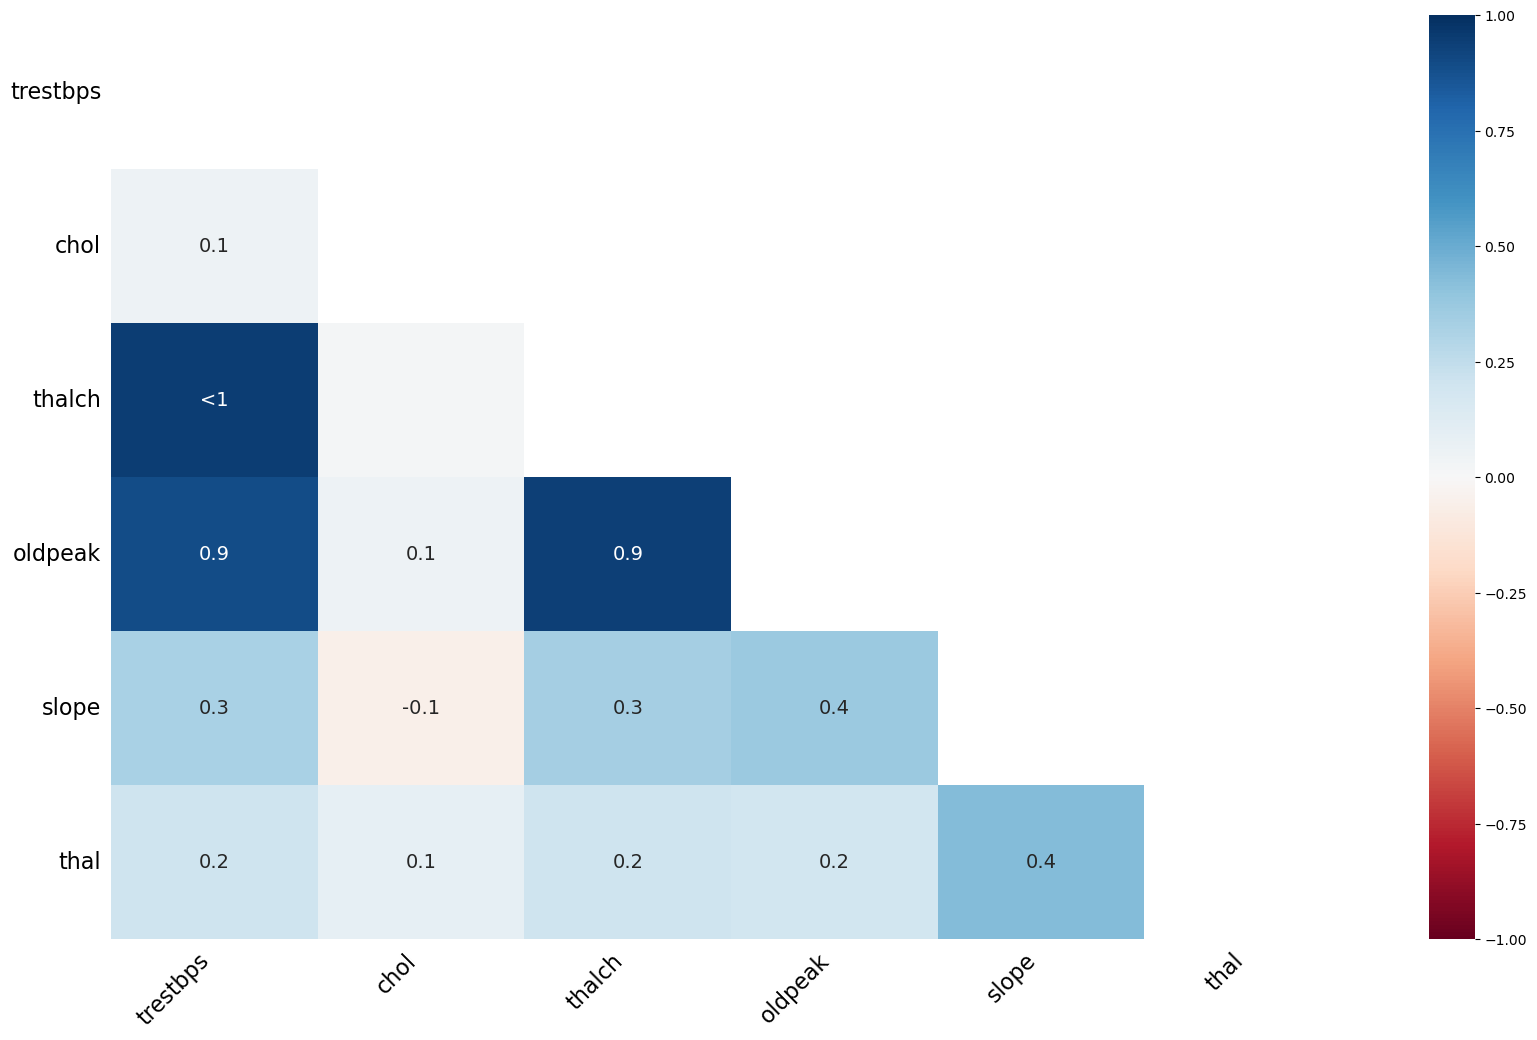

In [10]:
msno.heatmap(X_train)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       920 non-null    int64  
 1   sex       920 non-null    object 
 2   cp        920 non-null    object 
 3   trestbps  860 non-null    float64
 4   chol      718 non-null    float64
 5   fbs       830 non-null    object 
 6   restecg   918 non-null    object 
 7   thalch    865 non-null    float64
 8   exang     865 non-null    object 
 9   oldpeak   858 non-null    float64
 10  slope     611 non-null    object 
 11  ca        920 non-null    int32  
 12  thal      434 non-null    object 
 13  num       920 non-null    int64  
dtypes: float64(4), int32(1), int64(2), object(7)
memory usage: 97.2+ KB


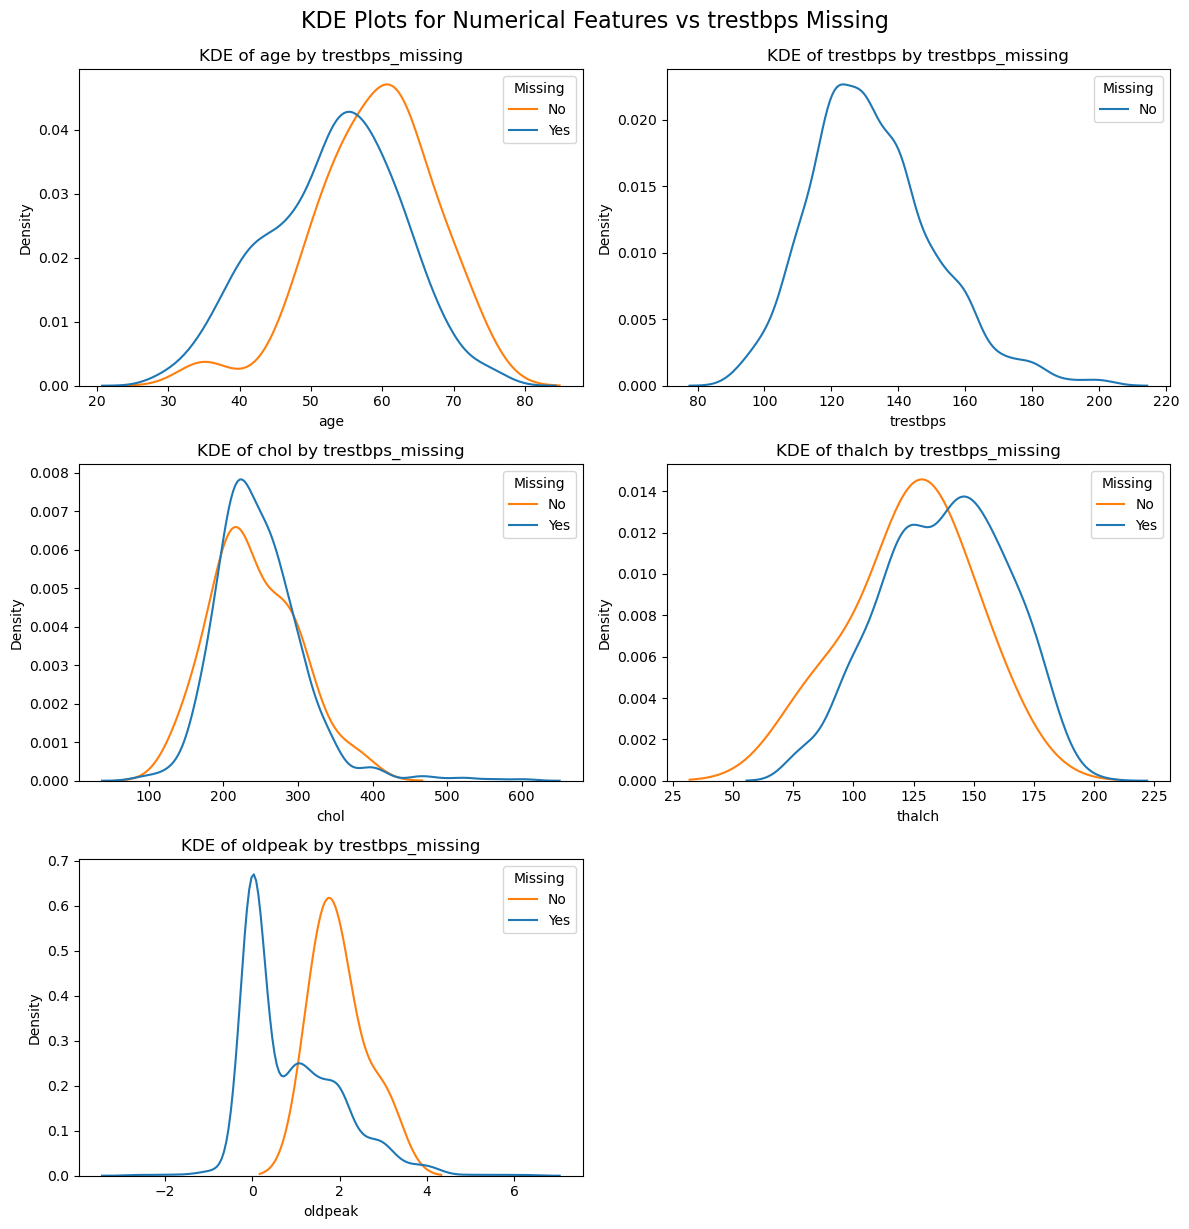

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
numerical_cols = ['age','trestbps','chol','thalch','oldpeak']
# 1. Create missingness indicator for 'trestbps'
df['trestbps_missing'] = df['trestbps'].isna()

# KDE PLOTS: Numerical Features vs trestbps_missing
n = len(numerical_cols)
rows = int(np.ceil(n / 2))
fig, axes = plt.subplots(rows, 2, figsize=(12, 4 * rows))

for i, col in enumerate(numerical_cols):
    ax = axes[i // 2, i % 2]
    sns.kdeplot(data=df, x=col, hue='trestbps_missing', common_norm=False, ax=ax)
    ax.set_title(f'KDE of {col} by trestbps_missing')
    ax.set_xlabel(col)
    ax.set_ylabel("Density")
    ax.legend(title='Missing', labels=["No", "Yes"])

# Hide empty plot if odd number of columns
if n % 2 != 0:
    fig.delaxes(axes[rows - 1, 1])

plt.tight_layout()
plt.suptitle("KDE Plots for Numerical Features vs trestbps Missing", fontsize=16, y=1.02)
plt.show()


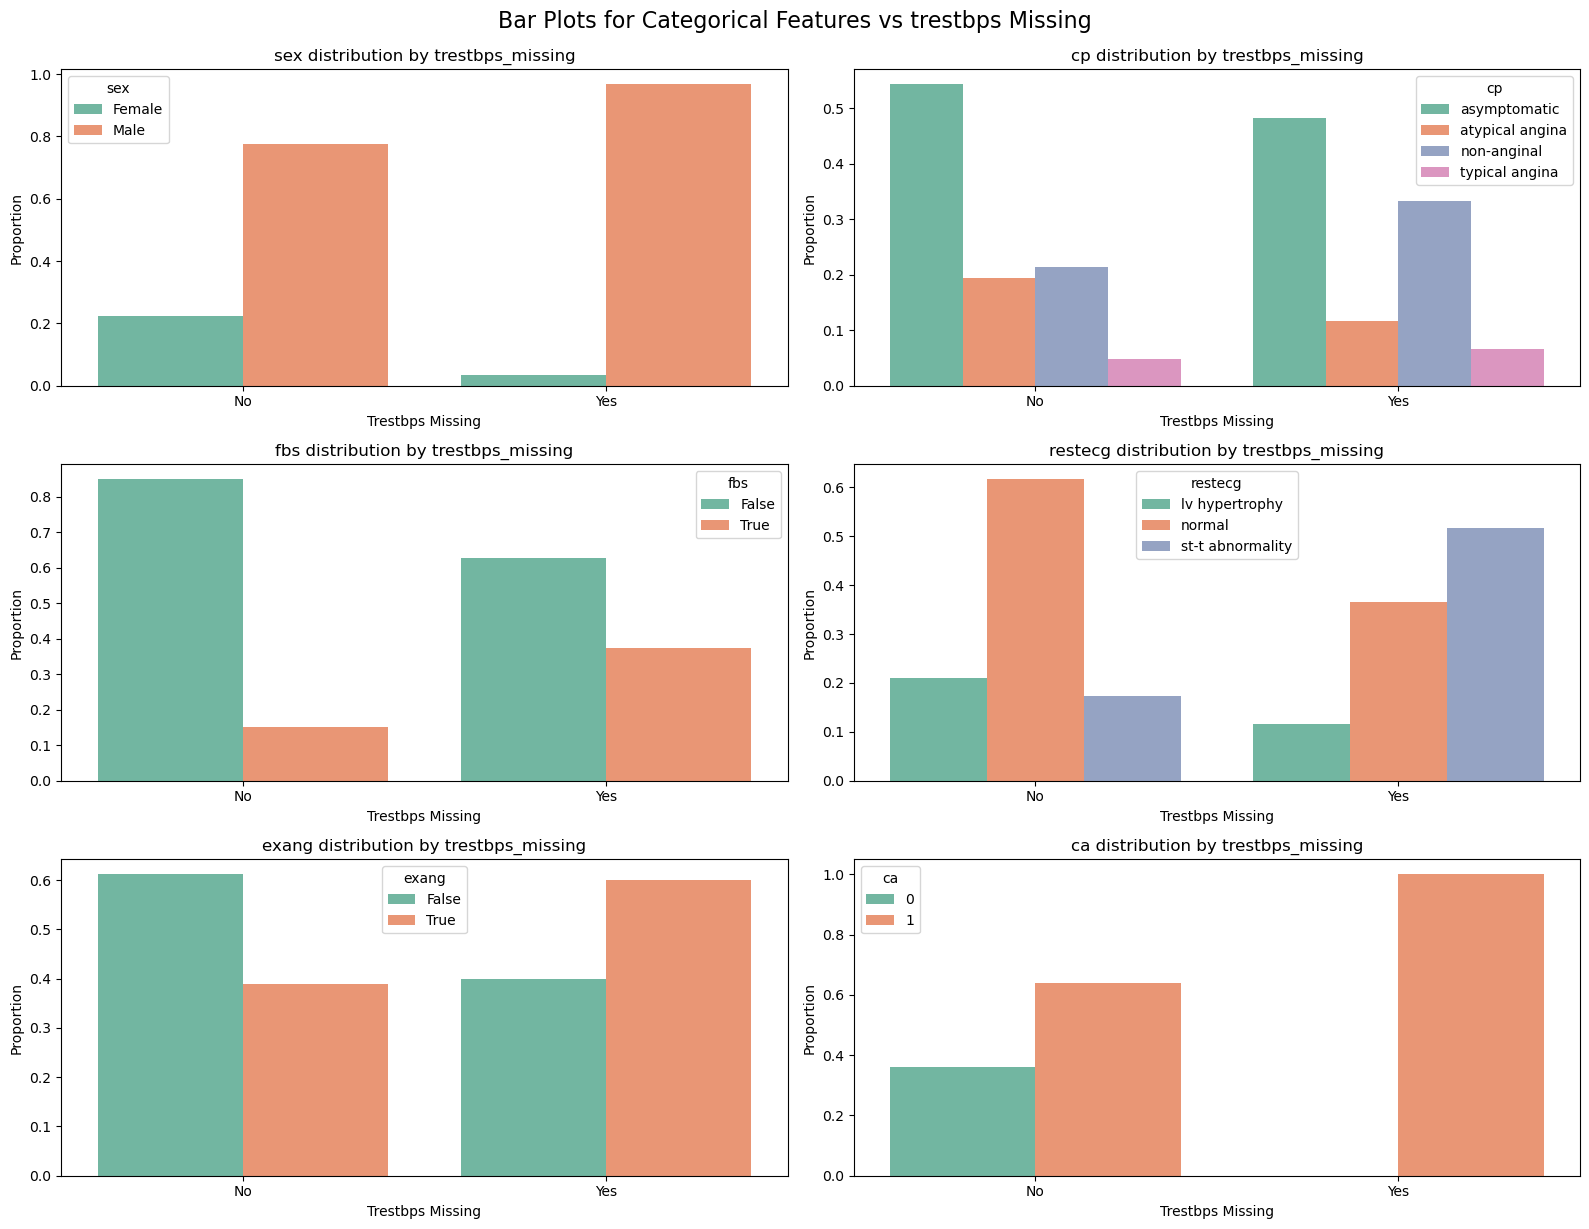

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
categorical_cols = ['sex','cp','fbs','restecg','exang','ca'] # NOt adding slope , ca , thal since they themselve contain more 30% percent null values so not relying on them 
# BAR PLOTS: Categorical Features vs trestbps_missing
n = len(categorical_cols)
rows = (n + 1) // 2
fig, axes = plt.subplots(nrows=rows, ncols=2, figsize=(16, 4 * rows))

axes = axes.flatten() if n > 1 else [axes]

for i, col in enumerate(categorical_cols):
    ax = axes[i]

    prop_df = df.groupby(['trestbps_missing', col]).size().reset_index(name='count')
    total = prop_df.groupby('trestbps_missing')['count'].transform('sum')
    prop_df['percent'] = prop_df['count'] / total

    sns.barplot(
        data=prop_df,
        x='trestbps_missing',
        y='percent',
        hue=col,
        ax=ax,
        palette='Set2'
    )

    ax.set_title(f"{col} distribution by trestbps_missing")
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['No', 'Yes'])
    ax.set_xlabel("Trestbps Missing")
    ax.set_ylabel("Proportion")
    ax.legend(title=col)

# Remove extra subplot if odd number of columns
if n % 2 != 0:
    fig.delaxes(axes[-1])

plt.tight_layout()
plt.suptitle("Bar Plots for Categorical Features vs trestbps Missing", fontsize=16, y=1.02)
plt.show()


In [14]:
count_df = df.groupby(['trestbps_missing', 'sex']).size().reset_index(name='count')
count_df

,trestbps_missing,sex,count
0,False,Female,192
1,False,Male,668
2,True,Female,2
3,True,Male,58


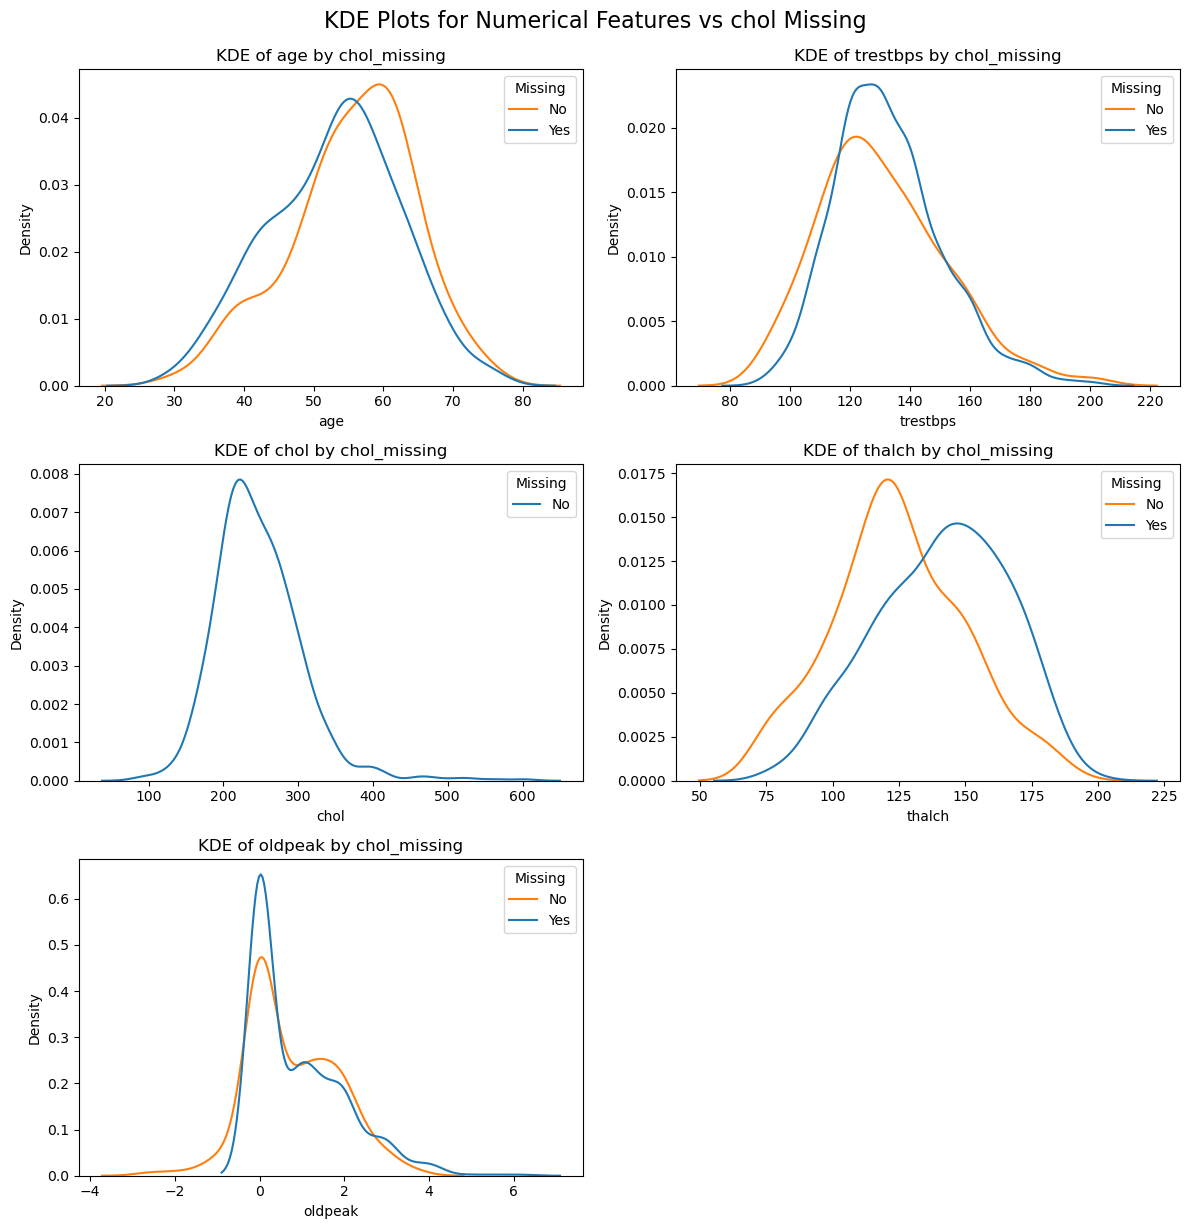

In [15]:
df['chol_missing'] = df['chol'].isna()
n = len(numerical_cols)
rows = int(np.ceil(n / 2))
fig, axes = plt.subplots(rows, 2, figsize=(12, 4 * rows))

for i, col in enumerate(numerical_cols):
    ax = axes[i // 2, i % 2]
    sns.kdeplot(data=df, x=col, hue='chol_missing', common_norm=False, ax=ax)
    ax.set_title(f'KDE of {col} by chol_missing')
    ax.set_xlabel(col)
    ax.set_ylabel("Density")
    ax.legend(title='Missing', labels=["No", "Yes"])

# Hide empty subplot if odd
if n % 2 != 0:
    fig.delaxes(axes[rows - 1, 1])

plt.tight_layout()
plt.suptitle("KDE Plots for Numerical Features vs chol Missing", fontsize=16, y=1.02)
plt.show()

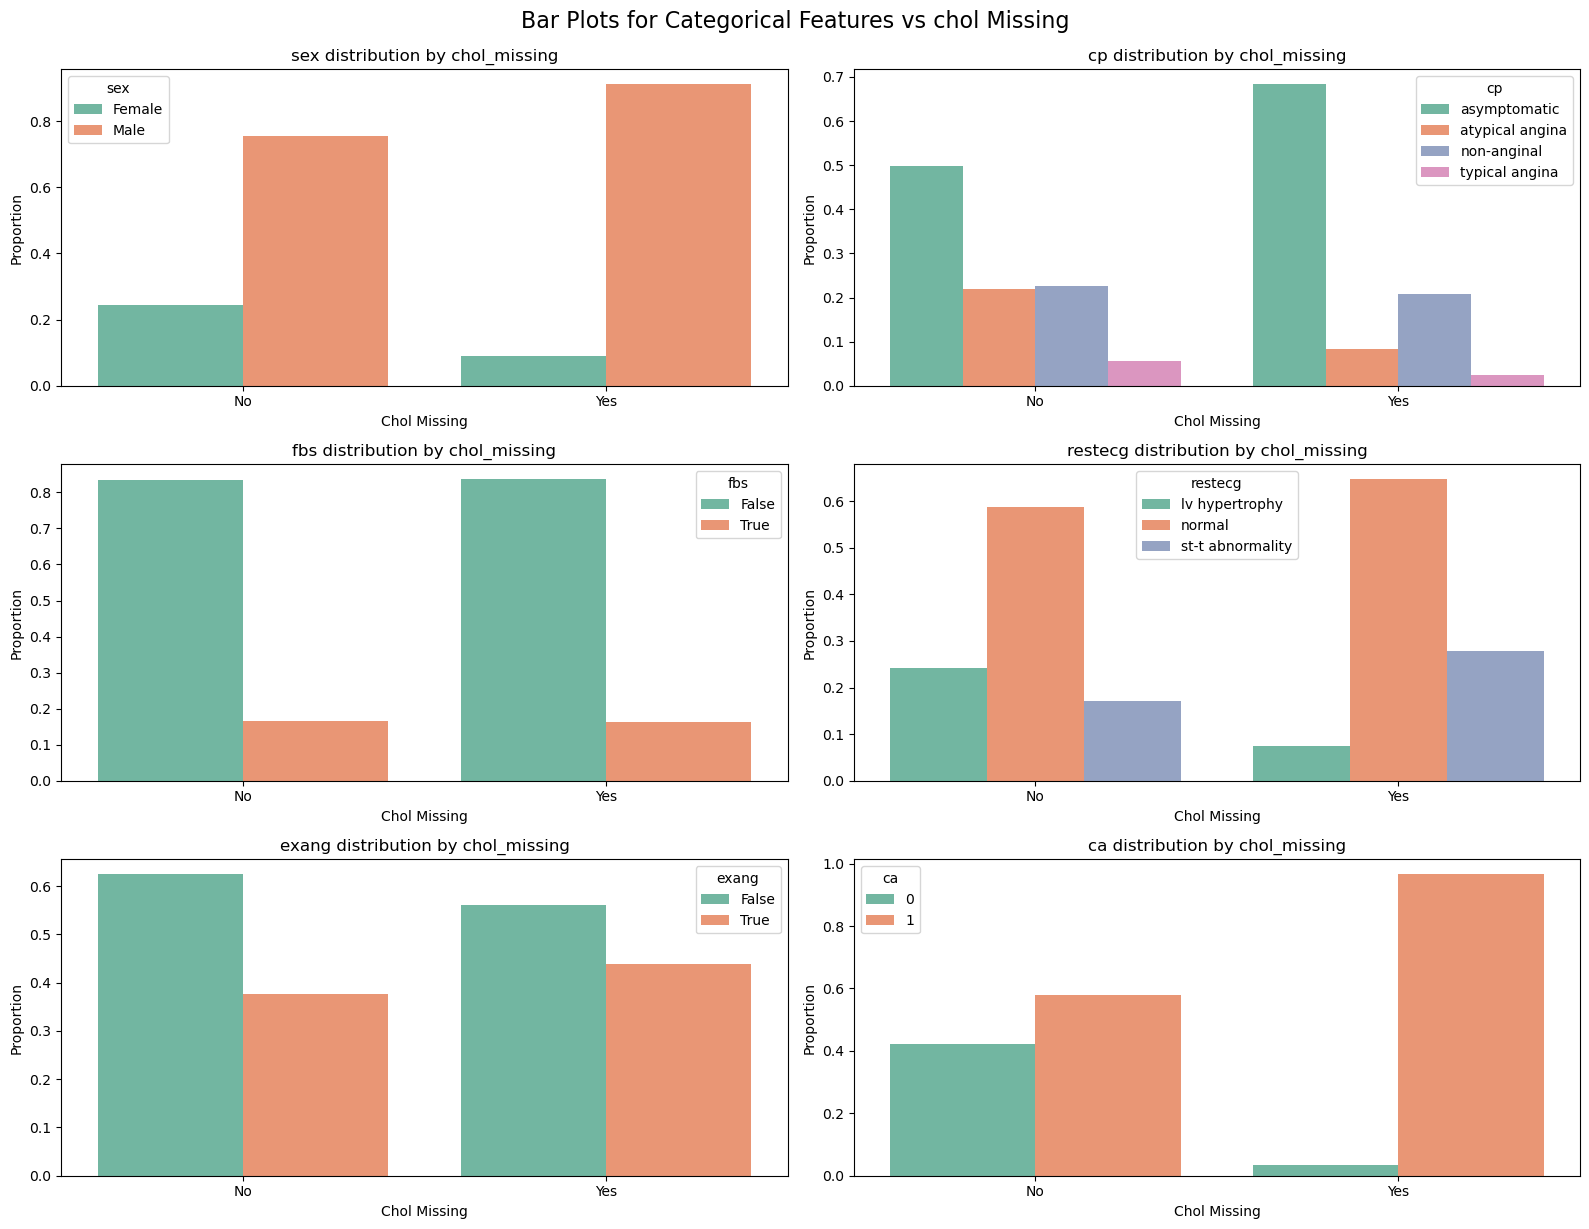

In [16]:
fig, axes = plt.subplots(nrows=(len(categorical_cols) + 1) // 2, ncols=2, figsize=(16, 4 * ((len(categorical_cols)+1)//2)))

# Flatten axes if needed
axes = axes.flatten() if len(categorical_cols) > 1 else [axes]

for i, col in enumerate(categorical_cols):
    ax = axes[i]

    prop_df = df.groupby(['chol_missing', col]).size().reset_index(name='count')
    total = prop_df.groupby('chol_missing')['count'].transform('sum')
    prop_df['percent'] = prop_df['count'] / total

    sns.barplot(
        data=prop_df,
        x='chol_missing',
        y='percent',
        hue=col,
        ax=ax,
        palette='Set2'
    )

    ax.set_title(f"{col} distribution by chol_missing")
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['No', 'Yes'])
    ax.set_xlabel("Chol Missing")
    ax.set_ylabel("Proportion")
    ax.legend(title=col)

# Remove empty axis if odd number
if len(categorical_cols) % 2 != 0:
    fig.delaxes(axes[-1])

plt.tight_layout()
plt.suptitle("Bar Plots for Categorical Features vs chol Missing", fontsize=16, y=1.02)
plt.show()


C:\Users\saini\AppData\Local\Temp\ipykernel_13368\1532647256.py:6: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=df, x=col, hue='thalch_missing', common_norm=False, ax=ax)


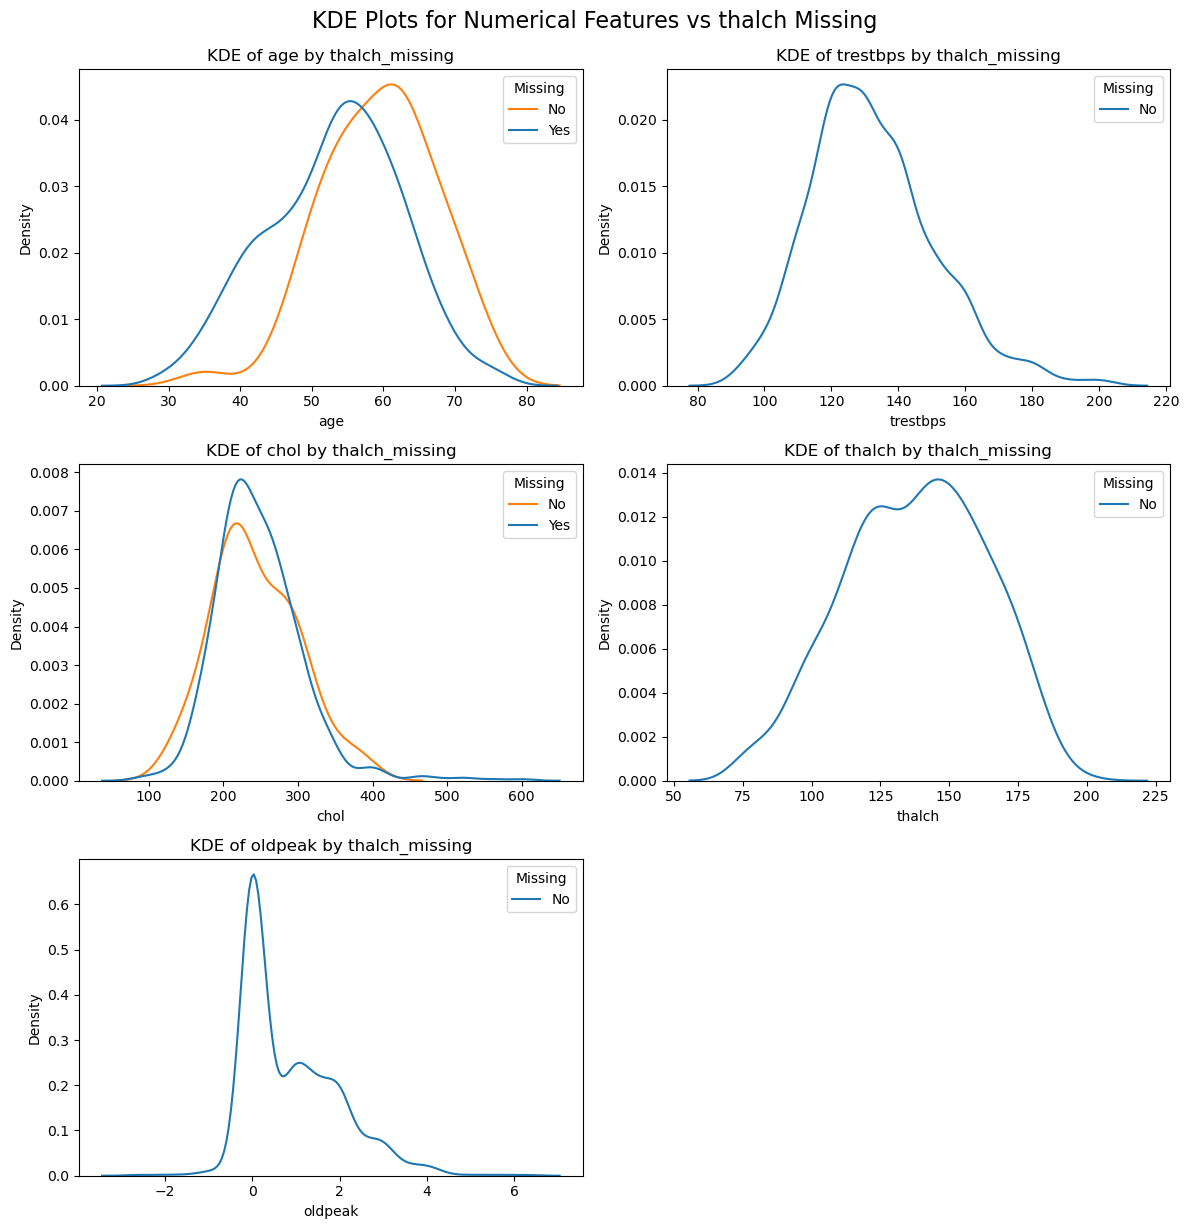

In [17]:
df['thalch_missing'] = df['thalch'].isna()
fig, axes = plt.subplots(rows, 2, figsize=(12, 4 * rows))

for i, col in enumerate(numerical_cols):
    ax = axes[i // 2, i % 2]
    sns.kdeplot(data=df, x=col, hue='thalch_missing', common_norm=False, ax=ax)
    ax.set_title(f'KDE of {col} by thalch_missing')
    ax.set_xlabel(col)
    ax.set_ylabel("Density")
    ax.legend(title='Missing', labels=["No", "Yes"])

# Hide empty plot if odd number
if n % 2 != 0:
    fig.delaxes(axes[rows - 1, 1])

plt.tight_layout()
plt.suptitle("KDE Plots for Numerical Features vs thalch Missing", fontsize=16, y=1.02)
plt.show()

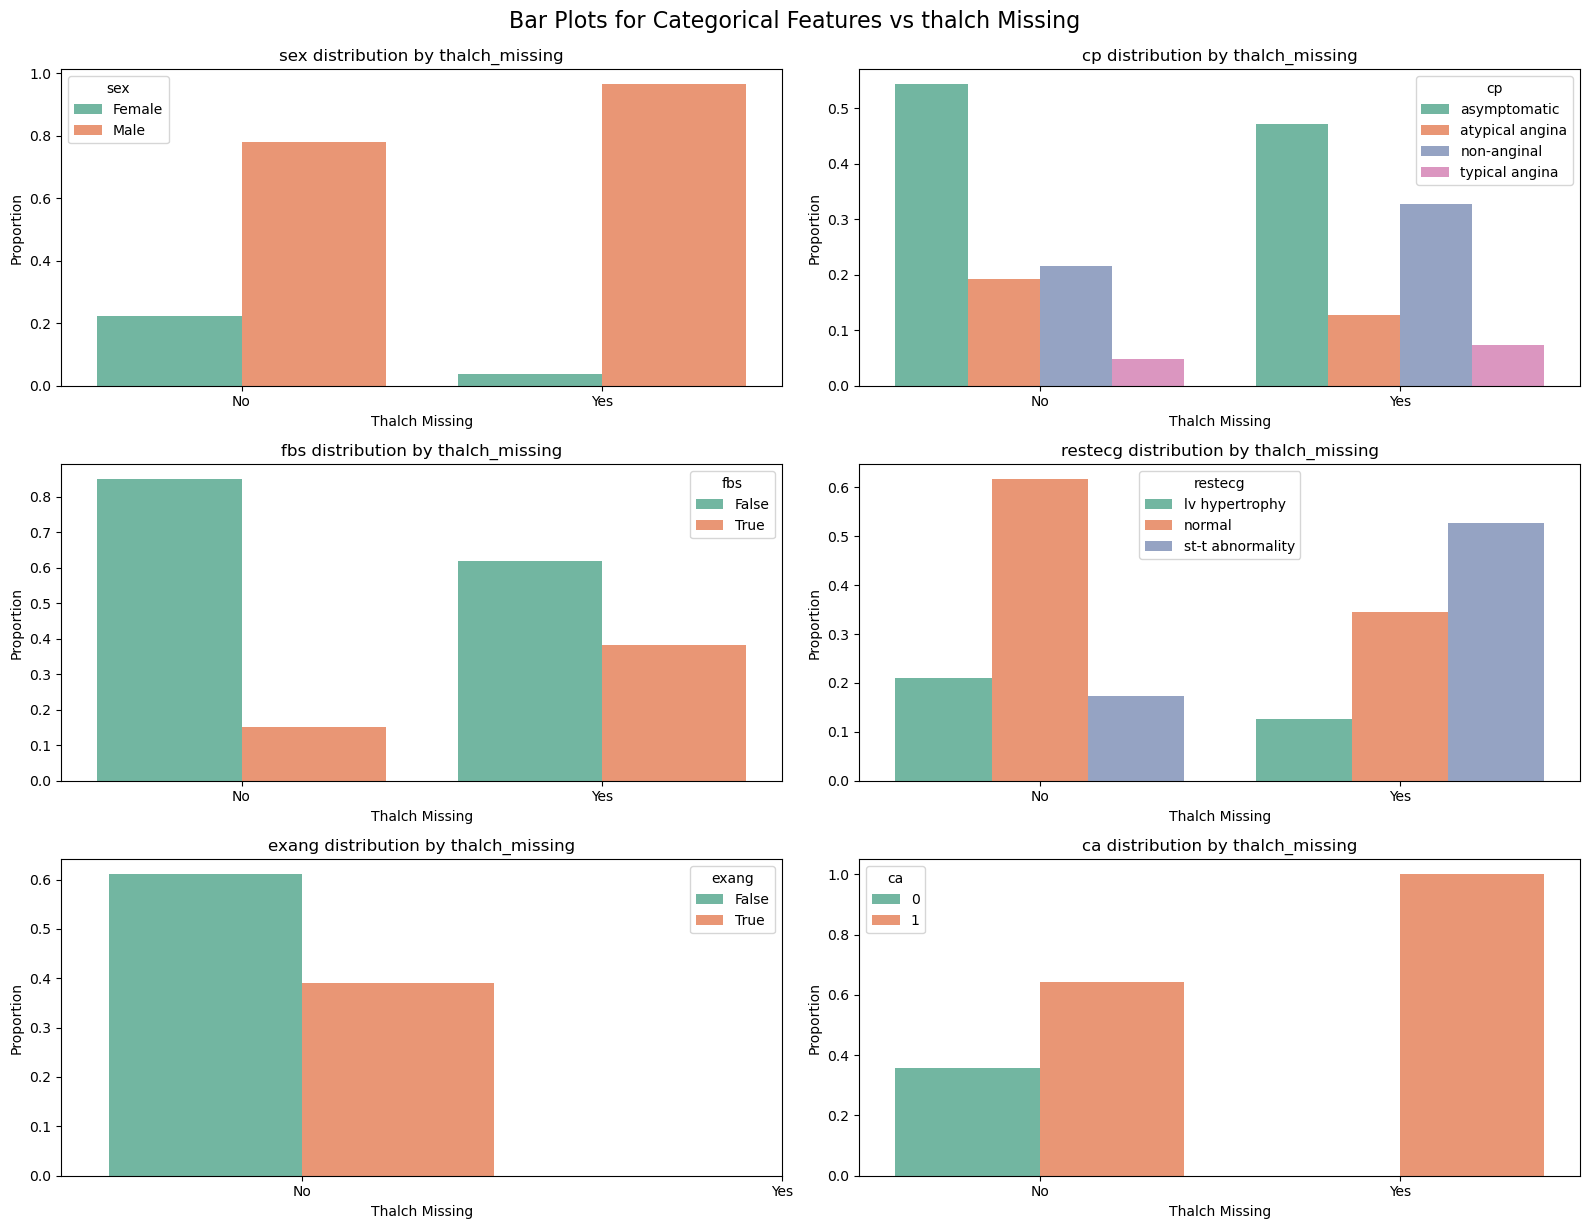

In [18]:
fig, axes = plt.subplots(nrows=(len(categorical_cols) + 1) // 2, ncols=2, figsize=(16, 4 * ((len(categorical_cols)+1)//2)))

axes = axes.flatten() if len(categorical_cols) > 1 else [axes]

for i, col in enumerate(categorical_cols):
    ax = axes[i]

    prop_df = df.groupby(['thalch_missing', col]).size().reset_index(name='count')
    total = prop_df.groupby('thalch_missing')['count'].transform('sum')
    prop_df['percent'] = prop_df['count'] / total

    sns.barplot(
        data=prop_df,
        x='thalch_missing',
        y='percent',
        hue=col,
        ax=ax,
        palette='Set2'
    )

    ax.set_title(f"{col} distribution by thalch_missing")
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['No', 'Yes'])
    ax.set_xlabel("Thalch Missing")
    ax.set_ylabel("Proportion")
    ax.legend(title=col)

if len(categorical_cols) % 2 != 0:
    fig.delaxes(axes[-1])

plt.tight_layout()
plt.suptitle("Bar Plots for Categorical Features vs thalch Missing", fontsize=16, y=1.02)
plt.show()


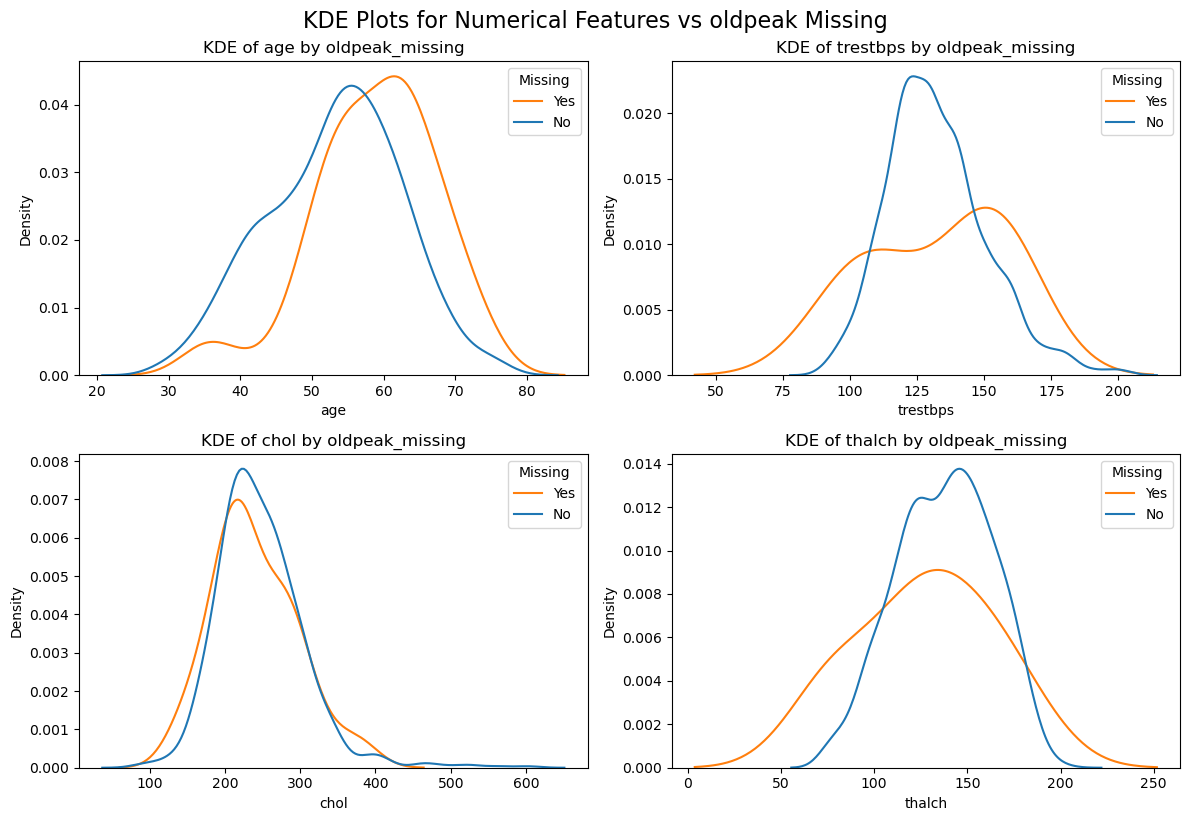

In [19]:
df['oldpeak_missing'] = df['oldpeak'].isna()

# List of your numerical columns
numerical_cols = ['age', 'trestbps', 'chol', 'thalch']  # modify if needed
n = len(numerical_cols)
rows = int(np.ceil(n / 2))

# Create subplots
fig, axes = plt.subplots(rows, 2, figsize=(12, 4 * rows))

for i, col in enumerate(numerical_cols):
    ax = axes[i // 2, i % 2]
    sns.kdeplot(data=df, x=col, hue='oldpeak_missing', common_norm=False, ax=ax)
    ax.set_title(f'KDE of {col} by oldpeak_missing')
    ax.set_xlabel(col)
    ax.set_ylabel("Density")
    ax.legend(title='Missing', labels=["Yes", "No"])

# Hide last empty plot if odd number of columns
if n % 2 != 0:
    fig.delaxes(axes[rows - 1, 1])

plt.tight_layout()
plt.suptitle("KDE Plots for Numerical Features vs oldpeak Missing", fontsize=16, y=1.02)
plt.show()

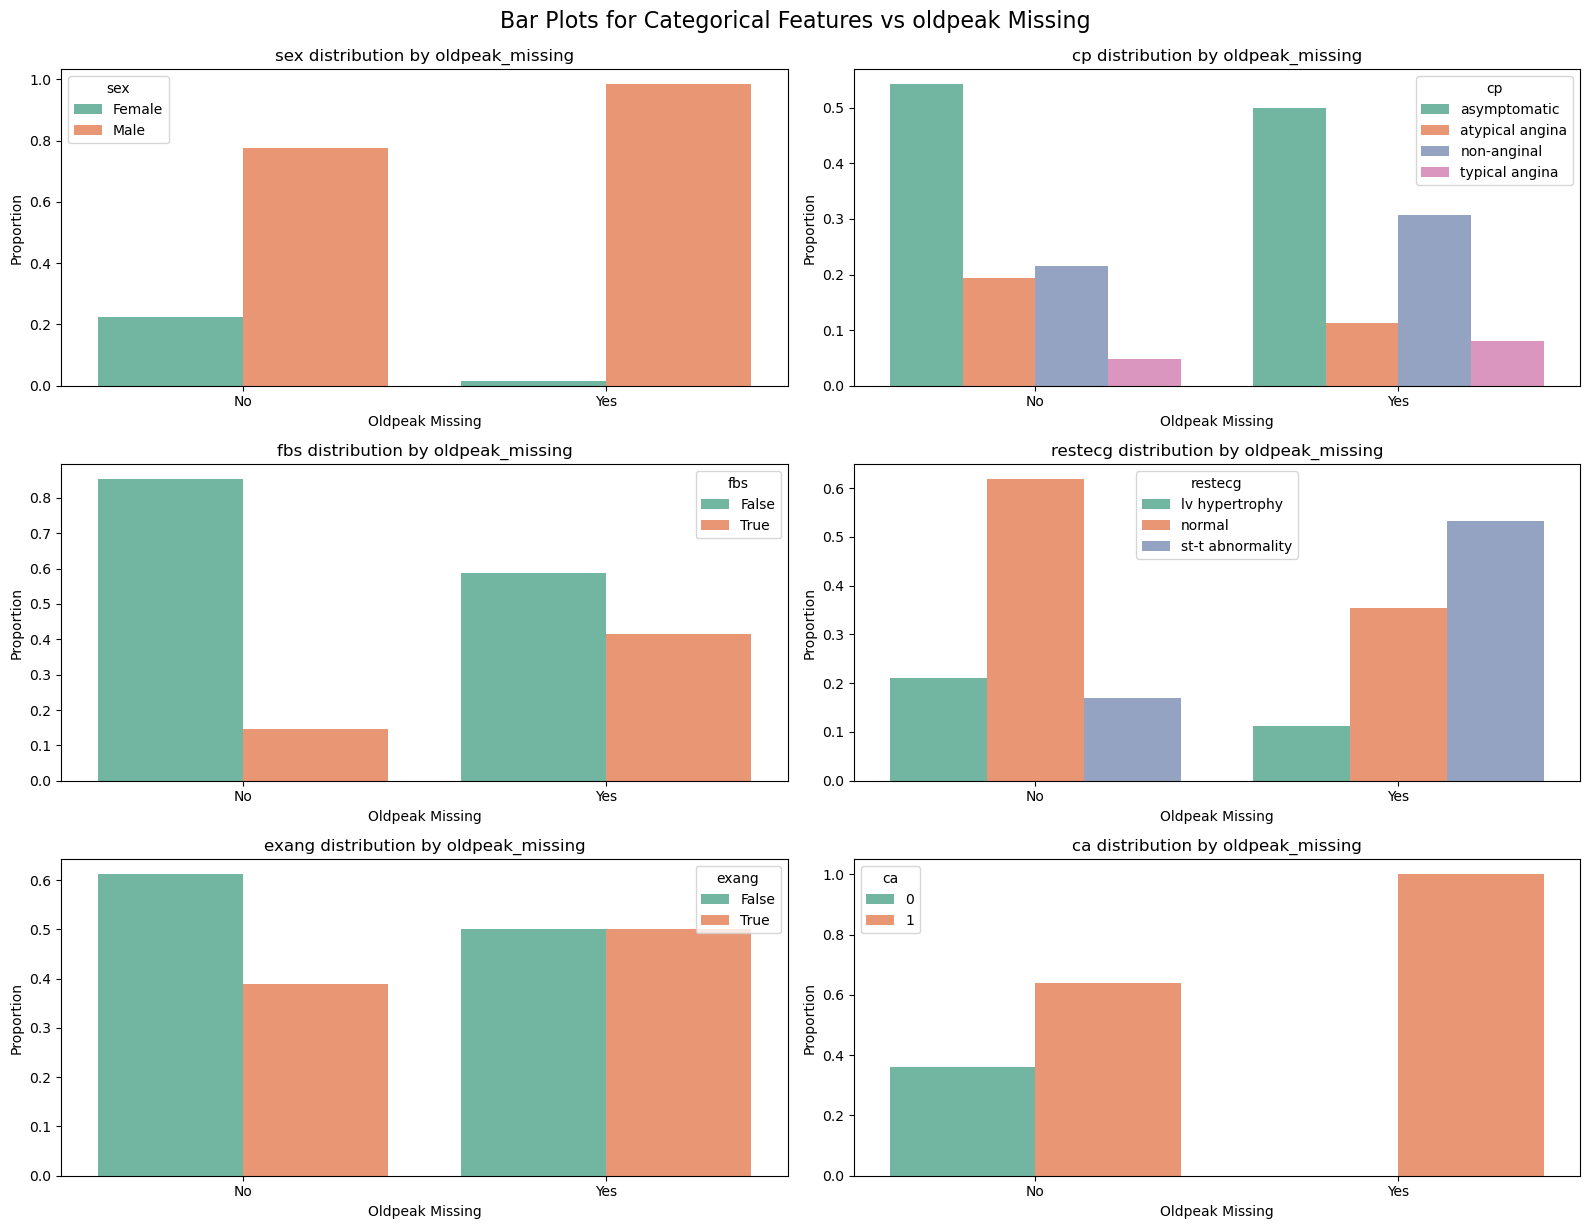

In [20]:
fig, axes = plt.subplots(nrows=(len(categorical_cols) + 1) // 2, ncols=2, figsize=(16, 4 * ((len(categorical_cols)+1)//2)))
axes = axes.flatten() if len(categorical_cols) > 1 else [axes]

for i, col in enumerate(categorical_cols):
    ax = axes[i]

    # Create a proportion dataframe
    prop_df = df.groupby(['oldpeak_missing', col]).size().reset_index(name='count')
    total = prop_df.groupby('oldpeak_missing')['count'].transform('sum')
    prop_df['percent'] = prop_df['count'] / total

    # Plotting
    sns.barplot(
        data=prop_df,
        x='oldpeak_missing',
        y='percent',
        hue=col,
        ax=ax,
        palette='Set2'
    )

    ax.set_title(f"{col} distribution by oldpeak_missing")
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['No', 'Yes'])
    ax.set_xlabel("Oldpeak Missing")
    ax.set_ylabel("Proportion")
    ax.legend(title=col)

# Remove empty axis if odd number of plots
if len(categorical_cols) % 2 != 0:
    fig.delaxes(axes[-1])

plt.tight_layout()
plt.suptitle("Bar Plots for Categorical Features vs oldpeak Missing", fontsize=16, y=1.02)
plt.show()

In [21]:
# Imputing 

In [22]:
cp_order =  [['typical angina', 'atypical angina', 'non-anginal', 'asymptomatic']]
slope_order = [['upsloping', 'flat', 'downsloping']]
thal_order =  [['normal', 'fixed defect', 'reversable defect']]
restecg_order =  [['normal','st-t abnormality','lv hypertrophy']]

#Ordinal Encoder 
ordinal_cp = OrdinalEncoder(categories=cp_order, handle_unknown='use_encoded_value',unknown_value = np.nan , dtype=float)
ordinal_slope = OrdinalEncoder(categories=slope_order, handle_unknown='use_encoded_value', unknown_value = np.nan, dtype=float)
ordinal_thal = OrdinalEncoder(categories=thal_order, handle_unknown='use_encoded_value', unknown_value = np.nan,dtype=float)
ordinal_restecg = OrdinalEncoder(categories= restecg_order,handle_unknown='use_encoded_value',unknown_value = np.nan, dtype=float)

def map_custom_categories(X):
    X = X.copy()
    
    sex_mapping = {'Female': 0 ,'Male': 1}
    
    exang_mapping = {False: 0,True: 1}

    fbs_mapping = {False: 0,True: 1}   


    X['sex'] = X['sex'].map(sex_mapping)
    X['exang'] = X['exang'].map(exang_mapping)
    X['fbs'] = X['fbs'].map(fbs_mapping)
 
    return X

binary_mapping = FunctionTransformer(map_custom_categories)

restecg_pipeline = Pipeline(steps=[("impute", SimpleImputer(strategy="most_frequent")),("encoding", ordinal_restecg)])
cp_encode = ordinal_cp
slope_encode = ordinal_slope


encoding_cat = ColumnTransformer(transformers=[
    ('restecg_pipeline', restecg_pipeline,['restecg']),
    ('binary_encoding',binary_mapping, ['sex','exang','fbs']),
    ('cp_encoding', cp_encode, ['cp']),
    ('slope_encoding',slope_encode, ['slope']),
    ('thal_encoding', ordinal_thal, ['thal'])
], remainder='passthrough',verbose_feature_names_out = False)



encoding_cat.set_output(transform='pandas')

X_train_transformed = encoding_cat.fit_transform(X_train)
X_test_transformed = encoding_cat.transform(X_test)

In [23]:
X_train_transformed.isnull().sum()

restecg       0
sex           0
exang         0
fbs           0
cp            0
slope       238
thal        390
age           0
trestbps     46
chol        164
thalch       42
oldpeak      45
ca            0
dtype: int64

In [66]:
X_train

,age,sex,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal
880,62,Male,asymptomatic,NaN,170.0,False,st-t abnormality,120.0,True,3.0,NaN,1,NaN
457,54,Male,non-anginal,150.0,NaN,False,normal,122.0,False,0.0,NaN,1,NaN
797,51,Male,non-anginal,NaN,339.0,False,normal,NaN,False,NaN,NaN,1,NaN
25,50,Female,non-anginal,120.0,219.0,False,normal,158.0,False,1.6,flat,0,normal
84,52,Male,atypical angina,120.0,325.0,False,normal,172.0,False,0.2,upsloping,0,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,59,Male,asymptomatic,140.0,177.0,False,normal,162.0,True,0.0,upsloping,0,reversable defect
270,61,Male,asymptomatic,140.0,207.0,False,lv hypertrophy,138.0,True,1.9,upsloping,0,reversable defect
860,75,Male,asymptomatic,160.0,310.0,True,normal,112.0,True,2.0,downsloping,1,reversable defect
435,53,Female,atypical angina,140.0,216.0,False,normal,142.0,True,2.0,flat,1,NaN


In [67]:
scale_columns = ['age','trestbps', 'chol' ,'thalch', 'oldpeak']

In [24]:
# Features used in KNN imputation\
from sklearn.impute import KNNImputer

knn_imputer = KNNImputer(n_neighbors=5)

knn_features = ['age', 'restecg', 'trestbps', 'thalch', 'oldpeak', 'exang']
impute_targets = ['trestbps', 'thalch', 'oldpeak']

# 3a. Fit on train, transform both train and test
X_train_knn = X_train_transformed[knn_features].copy()
X_test_knn = X_test_transformed[knn_features].copy()

X_train_knn_imputed = pd.DataFrame(knn_imputer.fit_transform(X_train_knn), 
                                   columns=knn_features, index=X_train_knn.index)

X_test_knn_imputed = pd.DataFrame(knn_imputer.transform(X_test_knn), 
                                  columns=knn_features, index=X_test_knn.index)

# Replace imputed targets in original train/test sets
X_train_transformed[impute_targets] = X_train_knn_imputed[impute_targets]
X_test_transformed[impute_targets] = X_test_knn_imputed[impute_targets]



In [25]:
X_train_transformed.isnull().sum()

restecg       0
sex           0
exang         0
fbs           0
cp            0
slope       238
thal        390
age           0
trestbps      0
chol        164
thalch        0
oldpeak       0
ca            0
dtype: int64

In [26]:
X_train_transformed = X_train_transformed[orginal_order]

In [27]:
X_train_transformed.isnull().sum()

age           0
sex           0
cp            0
trestbps      0
chol        164
fbs           0
restecg       0
thalch        0
exang         0
oldpeak       0
slope       238
ca            0
thal        390
dtype: int64

In [28]:
X_test_transformed = X_test_transformed[orginal_order]

In [29]:
# Select columns for imputation
features_for_chol = ['chol', 'fbs', 'thalch', 'age']

X_train_chol = X_train_transformed[features_for_chol].copy()
X_test_chol = X_test_transformed[features_for_chol].copy()

chol_imputer = IterativeImputer(estimator=RandomForestRegressor(n_estimators=10, random_state=0),
                                max_iter=10,
                                random_state=0)

# Fit on training data
X_train_chol_imputed = chol_imputer.fit_transform(X_train_chol)

# Transform test data using the same fitted imputer
X_test_chol_imputed = chol_imputer.transform(X_test_chol)

# Replace only 'chol' in X_train_transformed and X_test_transformed
X_train_transformed.loc[:, 'chol'] = X_train_chol_imputed[:, 0]
X_test_transformed.loc[:, 'chol'] = X_test_chol_imputed[:, 0]



In [30]:
X_train_transformed.isnull().sum()

age           0
sex           0
cp            0
trestbps      0
chol          0
fbs           0
restecg       0
thalch        0
exang         0
oldpeak       0
slope       238
ca            0
thal        390
dtype: int64

In [31]:
X_train_transformed

,age,sex,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal
880,62,1,3.0,125.2,170.0,0,1.0,120.000,1,3.0,NaN,1,NaN
457,54,1,2.0,150.0,233.8,0,0.0,122.000,0,0.0,NaN,1,NaN
797,51,1,2.0,123.6,339.0,0,0.0,128.112,0,0.3,NaN,1,NaN
25,50,0,2.0,120.0,219.0,0,0.0,158.000,0,1.6,1.0,0,0.0
84,52,1,1.0,120.0,325.0,0,0.0,172.000,0,0.2,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,59,1,3.0,140.0,177.0,0,0.0,162.000,1,0.0,0.0,0,2.0
270,61,1,3.0,140.0,207.0,0,2.0,138.000,1,1.9,0.0,0,2.0
860,75,1,3.0,160.0,310.0,1,0.0,112.000,1,2.0,2.0,1,2.0
435,53,0,1.0,140.0,216.0,0,0.0,142.000,1,2.0,1.0,1,NaN


In [32]:
from sklearn.impute import SimpleImputer

# Copy the original
X_train_imputed = X_train.copy()

# Define the columns you want to impute
median_cols = ['trestbps', 'thalch', 'oldpeak', 'chol']

# Initialize the imputer
median_imputer = SimpleImputer(strategy='median')

# Fit and transform
X_train_imputed[median_cols] = median_imputer.fit_transform(X_train_imputed[median_cols])
X_train_imputed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 736 entries, 880 to 102
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       736 non-null    int64  
 1   sex       736 non-null    object 
 2   cp        736 non-null    object 
 3   trestbps  736 non-null    float64
 4   chol      736 non-null    float64
 5   fbs       736 non-null    object 
 6   restecg   736 non-null    object 
 7   thalch    736 non-null    float64
 8   exang     736 non-null    object 
 9   oldpeak   736 non-null    float64
 10  slope     498 non-null    object 
 11  ca        736 non-null    int32  
 12  thal      346 non-null    object 
dtypes: float64(4), int32(1), int64(1), object(7)
memory usage: 77.6+ KB


In [33]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

# Columns to use
knn_features = ['age',  'trestbps', 'thalch', 'oldpeak', 'exang','chol','ca']
impute_targets = ['trestbps', 'thalch', 'oldpeak','chol']

# Copy to avoid altering original
X_train_iter = X_train.copy()

# Subset for imputation
X_sub = X_train_iter[knn_features]

# Define the Iterative Imputer
iter_imputer = IterativeImputer(
    estimator=RandomForestRegressor(n_estimators=10, random_state=0),
    max_iter=10,
    random_state=0
)

# Fit and transform
X_imputed = iter_imputer.fit_transform(X_sub)

# Put back into DataFrame
X_imputed_df = pd.DataFrame(X_imputed, columns=knn_features, index=X_sub.index)

# Update original X_train_iter only for target columns
X_train_iter[impute_targets] = X_imputed_df[impute_targets]


C:\Users\saini\AppData\Roaming\Python\Python312\site-packages\sklearn\impute\_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [34]:
X_train_iter.info()

<class 'pandas.core.frame.DataFrame'>
Index: 736 entries, 880 to 102
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       736 non-null    int64  
 1   sex       736 non-null    object 
 2   cp        736 non-null    object 
 3   trestbps  736 non-null    float64
 4   chol      736 non-null    float64
 5   fbs       736 non-null    object 
 6   restecg   736 non-null    object 
 7   thalch    736 non-null    float64
 8   exang     736 non-null    object 
 9   oldpeak   736 non-null    float64
 10  slope     498 non-null    object 
 11  ca        736 non-null    int32  
 12  thal      346 non-null    object 
dtypes: float64(4), int32(1), int64(1), object(7)
memory usage: 77.6+ KB


<Axes: xlabel='trestbps', ylabel='Density'>

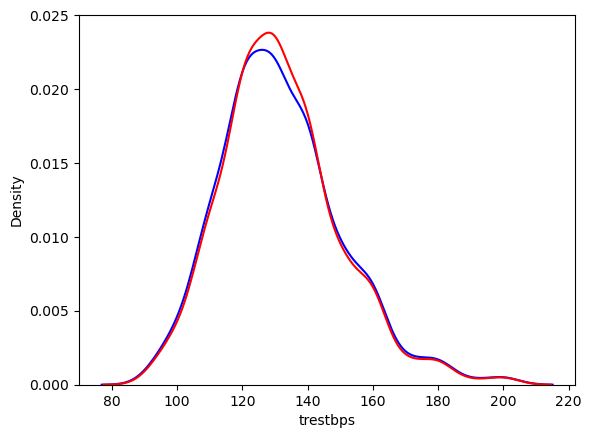

In [35]:
sns.kdeplot(X_train['trestbps'],color = "blue")
sns.kdeplot(X_train_iter['trestbps'],color = "red")

<Axes: xlabel='trestbps', ylabel='Density'>

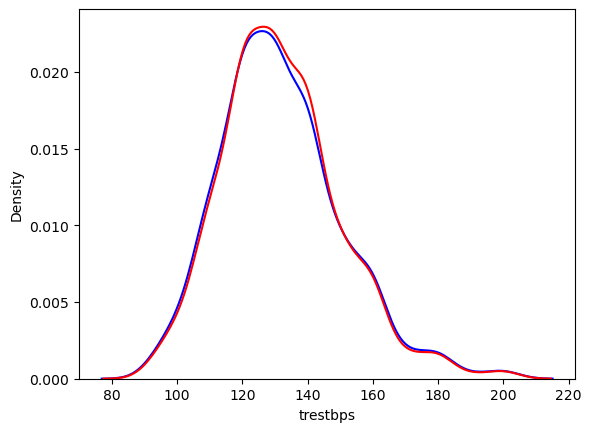

In [36]:
sns.kdeplot(X_train['trestbps'],color = "blue")
sns.kdeplot(X_train_transformed['trestbps'],color = "red")

<Axes: xlabel='trestbps', ylabel='Density'>

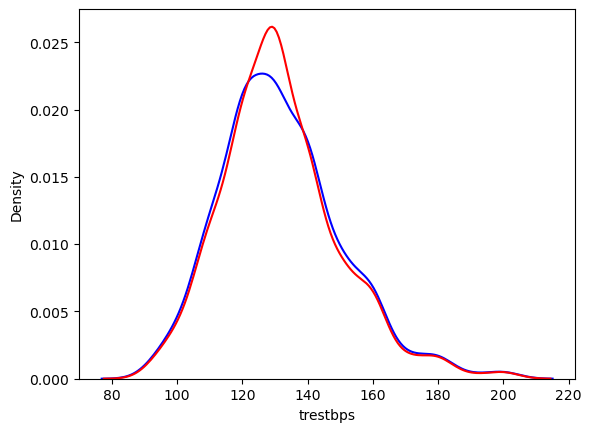

In [37]:
sns.kdeplot(X_train['trestbps'],color = "blue")
sns.kdeplot(X_train_imputed['trestbps'],color = "red")

<Axes: xlabel='chol', ylabel='Density'>

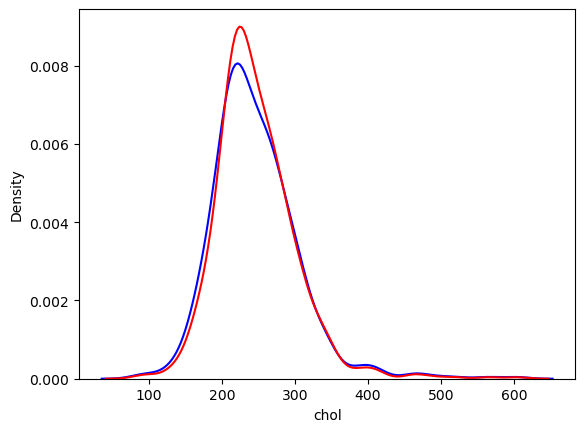

In [38]:
sns.kdeplot(X_train['chol'],color = "blue")
sns.kdeplot(X_train_iter['chol'],color = "red")

<Axes: xlabel='chol', ylabel='Density'>

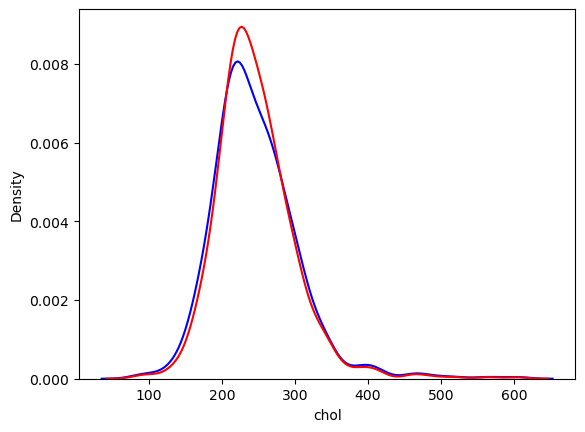

In [39]:
sns.kdeplot(X_train['chol'],color = "blue")
sns.kdeplot(X_train_transformed['chol'],color = "red")

<Axes: xlabel='chol', ylabel='Density'>

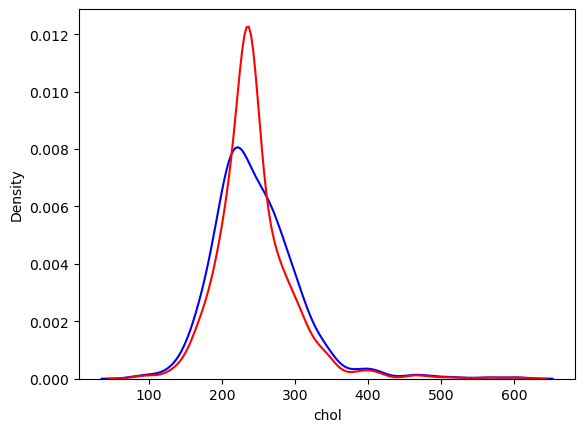

In [40]:
sns.kdeplot(X_train['chol'],color = "blue")
sns.kdeplot(X_train_imputed['chol'],color = "red")

<Axes: xlabel='thalch', ylabel='Density'>

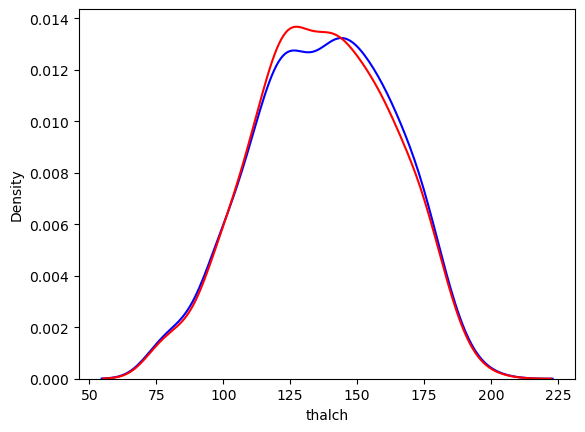

In [41]:
sns.kdeplot(X_train['thalch'],color = "blue")
sns.kdeplot(X_train_iter['thalch'],color = "red")

<Axes: xlabel='thalch', ylabel='Density'>

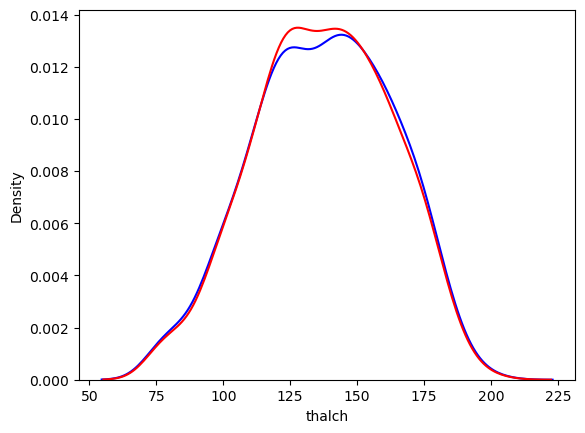

In [42]:
sns.kdeplot(X_train['thalch'],color = "blue")
sns.kdeplot(X_train_transformed['thalch'],color = "red")

<Axes: xlabel='thalch', ylabel='Density'>

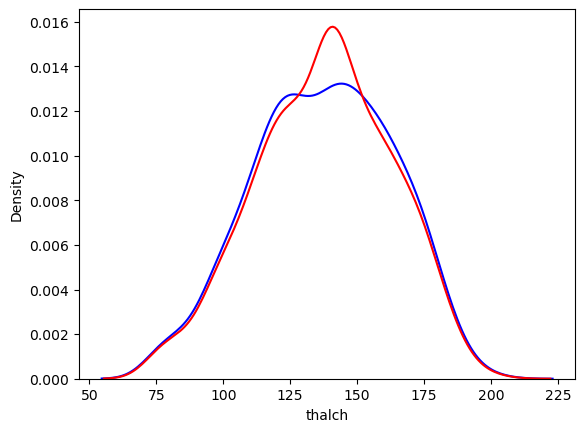

In [43]:
sns.kdeplot(X_train['thalch'],color = "blue")
sns.kdeplot(X_train_imputed['thalch'],color = "red")

<Axes: xlabel='oldpeak', ylabel='Density'>

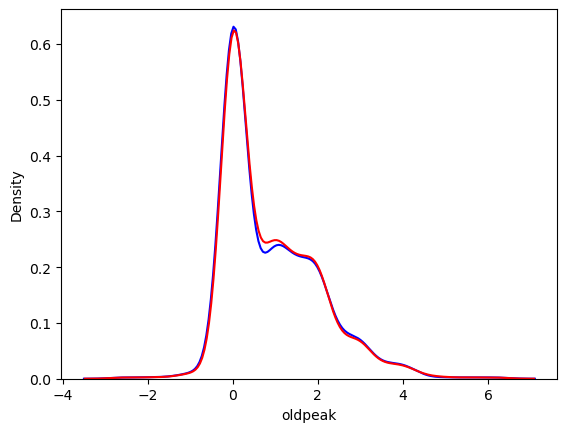

In [44]:
sns.kdeplot(X_train['oldpeak'],color = "blue")
sns.kdeplot(X_train_iter['oldpeak'],color = "red")

<Axes: xlabel='oldpeak', ylabel='Density'>

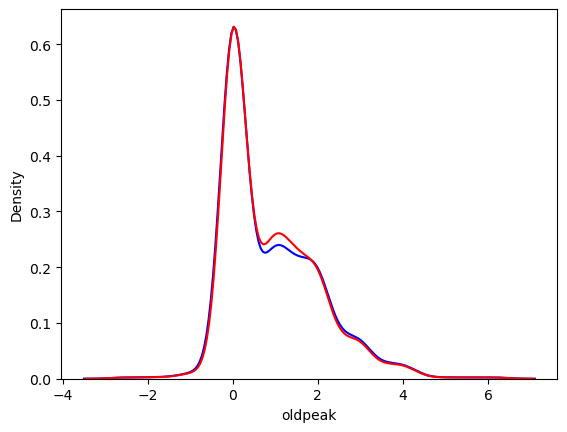

In [45]:
sns.kdeplot(X_train['oldpeak'],color = "blue")
sns.kdeplot(X_train_transformed['oldpeak'],color = "red")

<Axes: xlabel='oldpeak', ylabel='Density'>

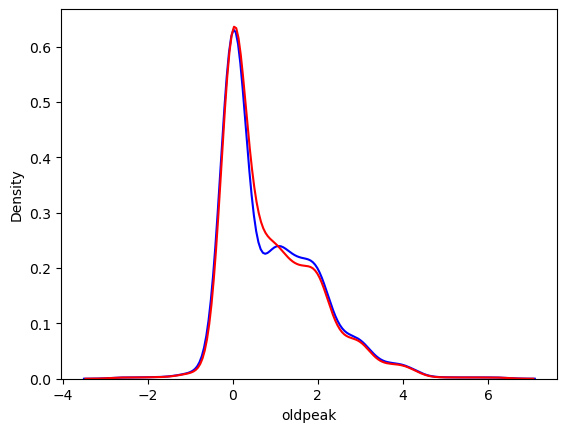

In [46]:
sns.kdeplot(X_train['oldpeak'],color = "blue")
sns.kdeplot(X_train_imputed['oldpeak'],color = "red")

In [47]:
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer, MissingIndicator

# --- SLOPE IMPUTATION (SimpleImputer with most frequent) ---
slope_imputer = SimpleImputer(strategy='most_frequent')

X_train_transformed['slope'] = slope_imputer.fit_transform(X_train_transformed[['slope']])
X_test_transformed['slope'] = slope_imputer.transform(X_test_transformed[['slope']])

# --- THAL MISSING INDICATOR ---
thal_indicator = MissingIndicator()

# Find missing values (returns boolean array)
thal_missing_train = thal_indicator.fit_transform(X_train_transformed[['thal']])
thal_missing_test = thal_indicator.transform(X_test_transformed[['thal']])

# Add new column 'thal_missing'
X_train_transformed['thal_missing'] = thal_missing_train.astype(int)
X_test_transformed['thal_missing'] = thal_missing_test.astype(int)

X_train_transformed.drop('thal' , axis = 1,inplace = True)

X_test_transformed.drop('thal' , axis = 1 , inplace = True)

In [48]:
X_train_transformed.isnull().sum()

age             0
sex             0
cp              0
trestbps        0
chol            0
fbs             0
restecg         0
thalch          0
exang           0
oldpeak         0
slope           0
ca              0
thal_missing    0
dtype: int64

In [63]:
X_train_transformed

,age,trestbps,chol,thalch,oldpeak,slope,ca,thal_missing,sex_1,cp_1.0,cp_2.0,cp_3.0,fbs_1,restecg_1.0,restecg_2.0,exang_1
880,0.901224,-0.399043,-1.411646,-0.688065,1.996694,1.0,1,1,True,False,False,True,False,True,False,True
457,0.051927,0.973448,-0.241322,-0.608783,-0.827542,1.0,1,1,True,False,True,False,False,False,False,False
797,-0.266559,-0.487590,1.688427,-0.366495,-0.545119,1.0,1,1,True,False,True,False,False,False,False,False
25,-0.372721,-0.686823,-0.512808,0.818303,0.678717,1.0,0,0,False,False,True,False,False,False,False,False
84,-0.160397,-0.686823,1.431616,1.373281,-0.639260,0.0,0,0,True,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,0.582737,0.420025,-1.283240,0.976868,-0.827542,0.0,0,0,True,False,False,True,False,False,False,True
270,0.795061,0.420025,-0.732932,0.025478,0.961141,0.0,0,0,True,False,False,True,False,False,True,True
860,2.281330,1.526872,1.156462,-1.005196,1.055282,2.0,1,0,True,False,False,True,True,False,False,True
435,-0.054235,0.420025,-0.567839,0.184043,1.055282,1.0,1,1,False,True,False,False,False,False,False,True


In [60]:
df1 = pd.read_csv(r"C:\Users\saini\Downloads\heart_statlog_cleveland_hungary_final (1).csv")
df1.info()
df.duplicated().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1190 entries, 0 to 1189
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  1190 non-null   int64  
 1   sex                  1190 non-null   int64  
 2   chest pain type      1190 non-null   int64  
 3   resting bp s         1190 non-null   int64  
 4   cholesterol          1190 non-null   int64  
 5   fasting blood sugar  1190 non-null   int64  
 6   resting ecg          1190 non-null   int64  
 7   max heart rate       1190 non-null   int64  
 8   exercise angina      1190 non-null   int64  
 9   oldpeak              1190 non-null   float64
 10  ST slope             1190 non-null   int64  
 11  target               1190 non-null   int64  
dtypes: float64(1), int64(11)
memory usage: 111.7 KB


2

In [61]:
df1.duplicated().sum()

272

In [62]:
df

,age,sex,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num,trestbps_missing,chol_missing,thalch_missing,oldpeak_missing
0,63,Male,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0,fixed defect,0,False,False,False,False
1,67,Male,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,0,normal,1,False,False,False,False
2,67,Male,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,0,reversable defect,1,False,False,False,False
3,37,Male,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0,normal,0,False,False,False,False
4,41,Female,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0,normal,0,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
915,54,Female,asymptomatic,127.0,333.0,True,st-t abnormality,154.0,False,0.0,NaN,1,NaN,1,False,False,False,False
916,62,Male,typical angina,NaN,139.0,False,st-t abnormality,NaN,NaN,NaN,NaN,1,NaN,0,True,False,True,True
917,55,Male,asymptomatic,122.0,223.0,True,st-t abnormality,100.0,False,0.0,NaN,1,fixed defect,1,False,False,False,False
918,58,Male,asymptomatic,NaN,385.0,True,lv hypertrophy,NaN,NaN,NaN,NaN,1,NaN,0,True,False,True,True
